<a href="https://colab.research.google.com/github/fabioFernandesBR/ML_Kidney_Stone/blob/main/Estudo_Modelos_Classifica%C3%A7%C3%A3o_Pedra_nos_Rins_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curso de Especialização em Engenharia de Software - PUC Rio.
## Sprint: Qualidade de Software, Segurança e Sistemas Inteligentes.
## Aluno: Fábio Fernandes
### Tema: Modelo de Machine Learning para previsão de pedra nos rins.

**Contexto e definição do problema:**
a partir de um conjunto de indicadores obtidos em um exame de urina, predizer a ocorrência de pedra nos rins, usando o valor 0 para "não, não tem pedra" e 1 para "sim, tem pedra".

**Passo 1:** Importação das bibliotecas necessárias

In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários

import pandas as pd #para ler arquivos csv e manipular os dataframes
import numpy as np #para cálculos matemáticos
import matplotlib.pyplot as plt #para construção e visualização de gráficos
import seaborn as sns #para construção e visualização de gráficos

## Importando Scikit Learn
### ATENÇÃO!!! AJUSTAR A VERSÃO DO SCIKIT LEARN COM A VERSÃO NO VISUAL STUDIO CODE
!pip install scikit-learn==1.5.2  #assim garantimos que estamos usando a mesma versão nos 2 ambientes

from sklearn.preprocessing import StandardScaler #Padronização dos dados
from sklearn.preprocessing import MinMaxScaler #Normalização dos dados
from sklearn.model_selection import train_test_split #Divisão do dataset em conjuntos para treino e teste
from sklearn.model_selection import KFold #Para validação cruzada
from sklearn.model_selection import StratifiedKFold #Variante do Kfold, para manter o número de classes em cada fold
from sklearn.model_selection import cross_val_score #Para determinar a pontuação em rotinas de cross validation
from sklearn.model_selection import GridSearchCV #Para otimização de hiperparâmetros
from sklearn.metrics import accuracy_score #Pontuação pela métrica de acurácia
from sklearn.pipeline import Pipeline #Para pipelines (normalização -> classificação, ou padronização -> classificação)
from sklearn.tree import DecisionTreeClassifier #Árvore de Classificação
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive Bayes
from sklearn.svm import SVC #Support Vector Machine

import pickle #para salvar modelos

**Passo 2:** Importação e carga do dataset

In [2]:
# URL de importação do dataset - Essa URL está no meu GitHub, mas eu a achei no Kaggle.com
url = "https://raw.githubusercontent.com/fabioFernandesBR/ML_Kidney_Stone/main/dataset/kidney_stone_urine_dataset.csv"


# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras e as últimas linhas do dataset
print(dataset.head(3))
print(dataset.tail(3))

   gravity    ph  osmo  cond  urea  calc  target
0    1.021  4.91   725  14.0   443  2.45       0
1    1.017  5.74   577  20.0   296  4.49       0
2    1.008  7.20   321  14.9   101  2.36       0
    gravity    ph  osmo  cond  urea   calc  target
76    1.024  5.40   803  21.8   394   7.82       1
77    1.016  6.81   594  21.4   255  12.20       1
78    1.015  6.03   416  12.8   178   9.39       1


Com base no print da célula anterior, sabemos que os dados foram importados com sucesso. Vamos agora checar se há dados faltantes.


**Passo 3:** Análise Exploratória de Dados


In [3]:
# 1. Informações gerais sobre o DataFrame (tipos de dados, valores não nulos)
print("\nInformações sobre os dados:")
print(dataset.info())

# 2. Resumo estatístico das variáveis numéricas
print("\nResumo estatístico das variáveis numéricas:")
print(dataset.describe())

# 3. Verificar valores faltantes
print("\nVerificar valores faltantes em cada coluna:")
print(dataset.isnull().sum())




Informações sobre os dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   gravity  79 non-null     float64
 1   ph       79 non-null     float64
 2   osmo     79 non-null     int64  
 3   cond     79 non-null     float64
 4   urea     79 non-null     int64  
 5   calc     79 non-null     float64
 6   target   79 non-null     int64  
dtypes: float64(4), int64(3)
memory usage: 4.4 KB
None

Resumo estatístico das variáveis numéricas:
         gravity         ph         osmo       cond        urea       calc  \
count  79.000000  79.000000    79.000000  79.000000   79.000000  79.000000   
mean    1.018114   6.028481   612.848101  20.813924  266.405063   4.138987   
std     0.007239   0.724307   237.514755   7.938994  131.254550   3.260051   
min     1.005000   4.760000   187.000000   5.100000   10.000000   0.170000   
25%     1.012000   5.530000   413.000

Vemos que não há dados faltantes neste dataset, então nenhum tratamento é necessário.



Distribuição das variáveis numéricas:


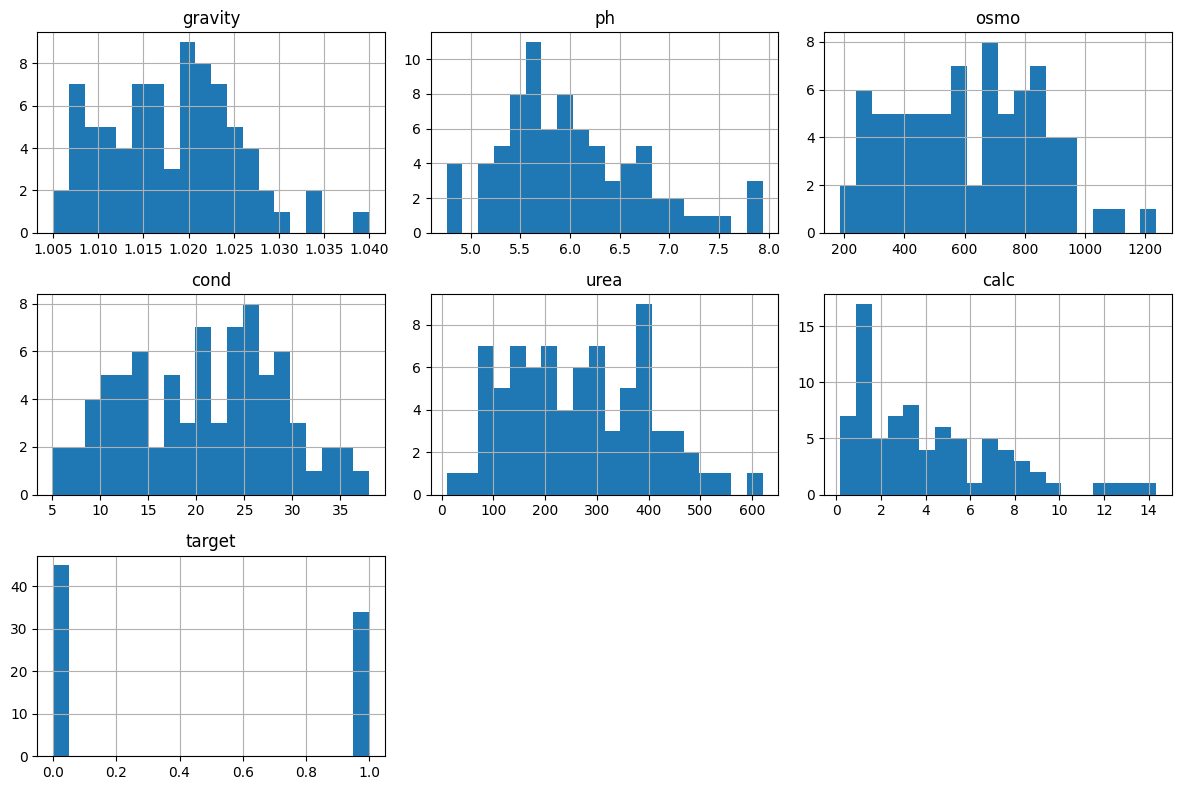

In [4]:
# 4. Distribuição das variáveis numéricas com histogramas
print("\nDistribuição das variáveis numéricas:")
dataset.hist(figsize=(12, 8), bins=20)
plt.tight_layout()
plt.show()



Vemos nos gráficos acima que as variáveis não seguem um padrão normal (gaussiana).
A variável target, como esperado, assume apenas os valores 0 ou 1.



Mapa de calor da correlação entre variáveis numéricas:


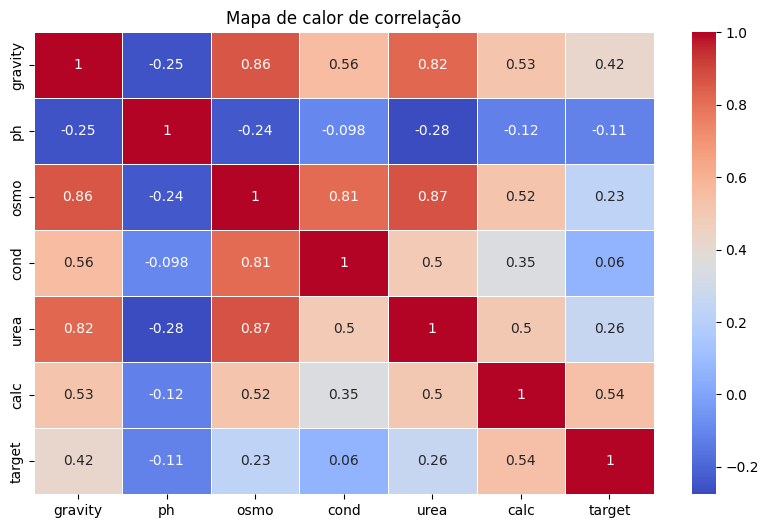

In [5]:
# 5. Análise de correlação (para variáveis numéricas)
print("\nMapa de calor da correlação entre variáveis numéricas:")
plt.figure(figsize=(10, 6))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Mapa de calor de correlação')
plt.show()




Boxplots para verificar possíveis outliers:


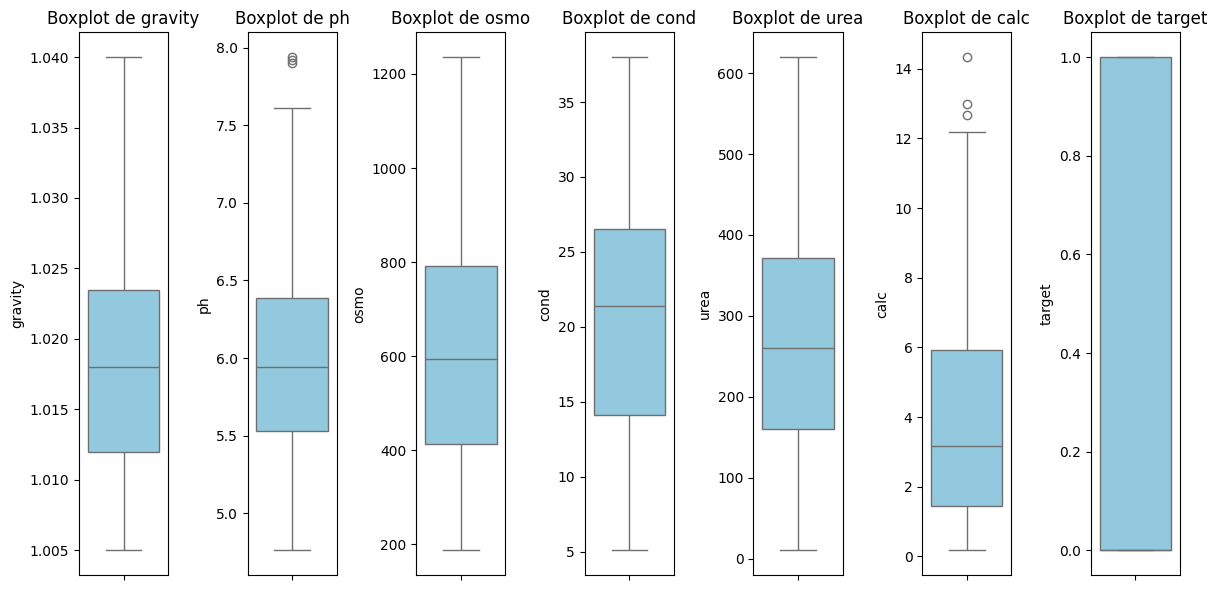

In [6]:
# 6. Boxplots para verificar possíveis outliers em variáveis numéricas
print("\nBoxplots para verificar possíveis outliers:")

# Definir o tamanho da figura
plt.figure(figsize=(12, 6))

# Iterar sobre as colunas numéricas para criar boxplots
for i, col in enumerate(dataset.select_dtypes(include=['float64', 'int64']).columns):
    plt.subplot(1, len(dataset.select_dtypes(include=['float64', 'int64']).columns), i+1)  # Subplots para múltiplos boxplots
    sns.boxplot(y=dataset[col], color='skyblue')  # Boxplot para cada coluna numérica
    plt.title(f'Boxplot de {col}')
    plt.tight_layout()  # Ajustar o layout

plt.show()





In [7]:
# 7. Verificar dados duplicados
print("\nVerificar se há dados duplicados:")
print(f"Total de dados duplicados: {dataset.duplicated().sum()}")


Verificar se há dados duplicados:
Total de dados duplicados: 0


Conclusão da análise: está tudo ok, vamos em frente com esses dados.

**Passo 4:** Configurar os parâmetros de aprendizagem e teste e realizar o hold out

In [9]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 35 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:6]
y = array[:,6]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'  #essa é métrica escolhida, acurácia. Poderia ser outra, mas optamos pela acurácia.
num_particoes = 8
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

**Passo 5:** Executar diferentes pipelines de modelos de classificação, incluindo padronização e normalização, e escolher 1 para otimização.

KNN-orig: 0.571 (0.175)
CART-orig: 0.652 (0.134)
NB-orig: 0.688 (0.177)
SVM-orig: 0.636 (0.143)
KNN-padr: 0.748 (0.106)
CART-padr: 0.636 (0.143)
NB-padr: 0.703 (0.176)
SVM-padr: 0.795 (0.085)
KNN-norm: 0.748 (0.106)
CART-norm: 0.683 (0.123)
NB-norm: 0.703 (0.176)
SVM-norm: 0.761 (0.117)

Melhor modelo: SVM-padr: 0.795


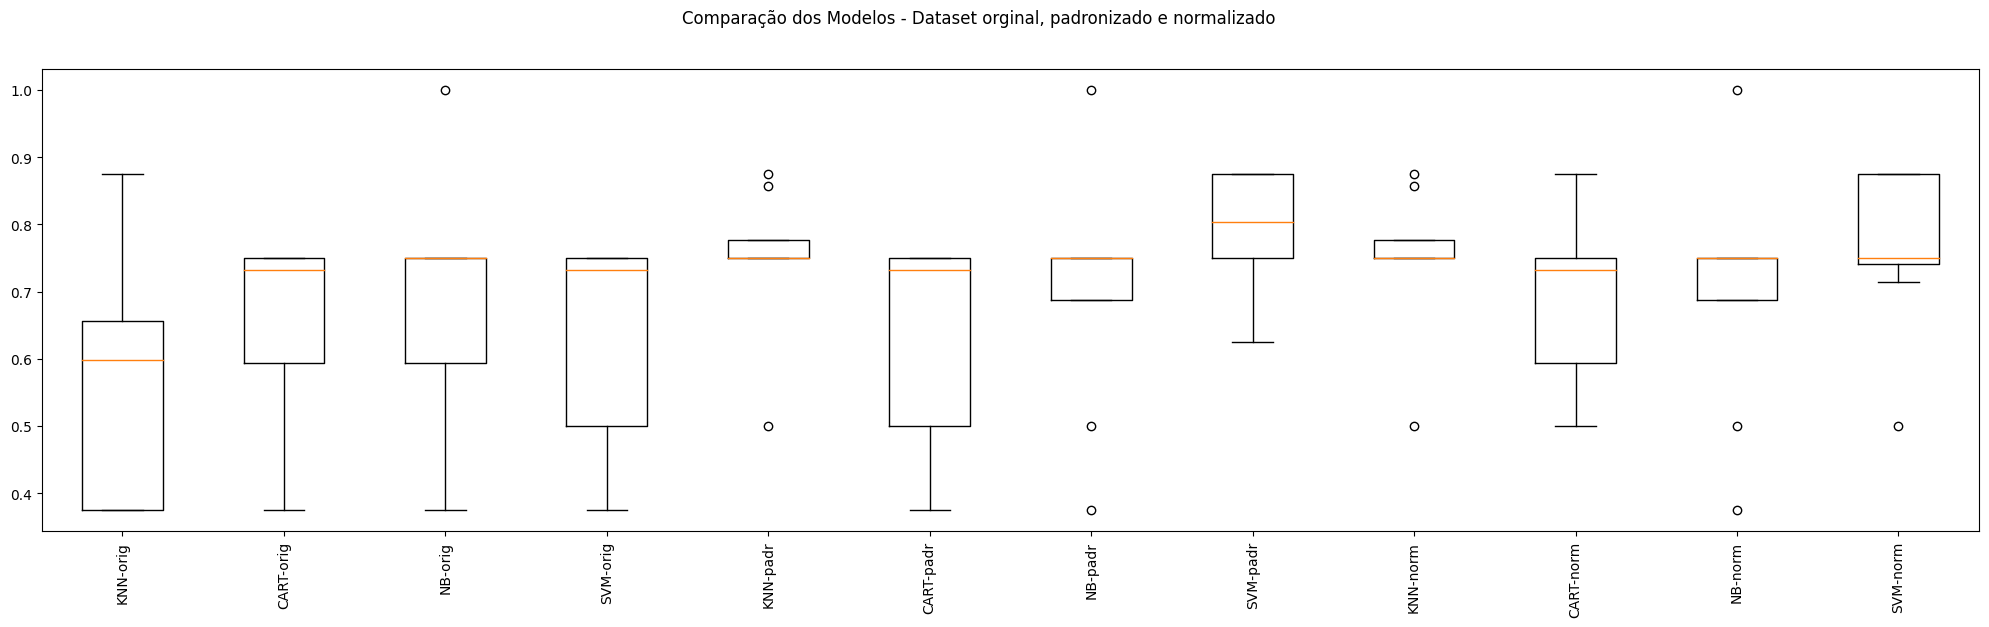

In [10]:
np.random.seed(seed) # usando a mesma semente definida em etapa anterior

# Listas para armazenar os pipelines e os resultados das avaliações de cada um dos modelos testados.
pipelines = []
results = []
names = []

# Para identificar o modelo de acurácia mais alta
best_accuracy = 0
best_model = ""

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler()) #scaler para padronização
min_max_scaler = ('MinMaxScaler', MinMaxScaler()) #scaler para normalização


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)
    if cv_results.mean() > best_accuracy:
        best_accuracy = cv_results.mean()
        best_model = name

resultado = "\nMelhor modelo: %s: %.3f" % (best_model, best_accuracy)
print(resultado)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

O modelo com melhor resultado foi o SVM com padronização dos dados. Esse modelo será refinado com otimização dos seus hiperparâmetros.

**Passo 6:** Otimização dos hiperparâmetros

In [11]:
# Tuning do SVM

np.random.seed(seed) # mesma semente

pipelines = []

# Definindo os componentes do pipeline
svm = ('SVM', SVC())
standard_scaler = ('StandardScaler', StandardScaler())


pipelines.append(('svm-padr', Pipeline(steps=[standard_scaler, svm])))

### O grid de parâmetros abaixo é mais completo, porém muito demorado:
param_grid = {
    'SVM__C': [0.1, 1, 10, 100],  # Parâmetro de regularização
    'SVM__kernel': ['linear', 'rbf', 'poly'],  # Tipos de kernel
    'SVM__gamma': ['scale', 'auto'],  # Coeficiente para o kernel 'rbf' e 'poly'
    'SVM__degree': [2, 3, 4]  # Apenas para o kernel 'poly'
}

### Por este motivo vou usar esta versão de grid de parâmetros.
param_grid = {
    'SVM__C': [0.1, 1, 10],  # Parâmetro de regularização
    'SVM__kernel': ['linear', 'rbf', 'poly'],  # Tipos de kernel
    'SVM__gamma': ['scale', 'auto'],  # Coeficiente para o kernel 'rbf' e 'poly'
    'SVM__degree': [2]  # Apenas para o kernel 'poly'
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    print(model)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, verbose = 3)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Pipeline(steps=[('StandardScaler', StandardScaler()), ('SVM', SVC())])
Fitting 8 folds for each of 18 candidates, totalling 144 fits
[CV 1/8] END SVM__C=0.1, SVM__degree=2, SVM__gamma=scale, SVM__kernel=linear;, score=0.500 total time=   0.0s
[CV 2/8] END SVM__C=0.1, SVM__degree=2, SVM__gamma=scale, SVM__kernel=linear;, score=0.625 total time=   0.0s
[CV 3/8] END SVM__C=0.1, SVM__degree=2, SVM__gamma=scale, SVM__kernel=linear;, score=0.750 total time=   0.0s
[CV 4/8] END SVM__C=0.1, SVM__degree=2, SVM__gamma=scale, SVM__kernel=linear;, score=0.875 total time=   0.0s
[CV 5/8] END SVM__C=0.1, SVM__degree=2, SVM__gamma=scale, SVM__kernel=linear;, score=1.000 total time=   0.0s
[CV 6/8] END SVM__C=0.1, SVM__degree=2, SVM__gamma=scale, SVM__kernel=linear;, score=0.750 total time=   0.0s
[CV 7/8] END SVM__C=0.1, SVM__degree=2, SVM__gamma=scale, SVM__kernel=linear;, score=0.875 total time=   0.0s
[CV 8/8] END SVM__C=0.1, SVM__degree=2, SVM__gamma=scale, SVM__kernel=linear;, score=0.857 total 

Pelos resultados acima (svm-padr - Melhor: 0.794643 usando {'SVM__C': 1, 'SVM__degree': 2, 'SVM__gamma': 'scale', 'SVM__kernel': 'rbf'}), identificamos que a melhor parametrização do modelo é obtida usando dados padronizados (StandardScaler), com parâmetros C = 1, gamma = "scale" e kernel "rbf", obtendo-se assim acurácia média de 79.46%.

Observe que a parametrização usou ainda o valor degree = 2, mas como este parâmetro só é usado com kernel polinomial, podemos ignorar este parâmetro.


**Passo 7:**  Finalização do Modelo

In [12]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = SVC(C=1, gamma='scale', kernel='rbf') # criação do modelo
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.8125


A acurácia do pipeline escolhido, com hiperparâmetros otimizados, apresenta acurácia de 81%, considerando os dados separados para teste.

In [13]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

SVC(C=1)

## Simulando a aplicação do modelo em dados não vistos

In [14]:
# Novos dados - não sabemos a classe!
data = {'gravity':  [1.021, 1.017, 1.008, 1.024, 1.016, 1.015, 1.008],
        'ph': [4.91, 5.74, 7.2, 5.4, 6.81, 6.03, 4.91],
        'osmo': [725, 577, 321, 803, 594, 416, 577],
        'cond': [14, 20, 14.9, 21.8, 21.4, 12.8, 21.4],
        'urea': [443, 296, 101, 394, 255, 178, 178],
        'calc': [2.45, 4.49, 2.36, 7.82, 12.2, 9.39, 12.2]
        }

'''
gravity	ph	  osmo	cond	urea	calc	target
1.021	  4.91	725	  14	  443	  2.45	0
1.017	  5.74	577	  20	  296	  4.49	0
1.008	  7.2	  321	  14.9	101	  2.36	0
1.024	  5.4	  803	  21.8	394	  7.82	1
1.016	  6.81	594	  21.4	255	  12.2	1
1.015	  6.03	416	  12.8	178	  9.39	1
'''

atributos = ['gravity', 'ph', 'osmo', 'cond', 'urea', 'calc']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,:].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[ 4.01205800e-01 -1.55407557e+00  4.75206400e-01 -8.63769897e-01
   1.35403573e+00 -5.21396603e-01]
 [-1.54851361e-01 -4.00830491e-01 -1.51894416e-01 -1.03177419e-01
   2.26918180e-01  1.08358898e-01]
 [-1.40597997e+00  1.62776928e+00 -1.23660934e+00 -7.49681025e-01
  -1.26823775e+00 -5.49179934e-01]
 [ 8.18248671e-01 -8.73244136e-01  8.05705479e-01  1.25000325e-01
   9.78329880e-01  1.13634214e+00]
 [-2.93865652e-01  1.08588304e+00 -7.98625655e-02  7.42941598e-02
  -8.74479387e-02  2.48846425e+00]
 [-4.32879942e-01  2.11055985e-03 -8.34078412e-01 -1.01588839e+00
  -6.77842845e-01  1.62100692e+00]
 [-1.40597997e+00 -1.55407557e+00 -1.51894416e-01  7.42941598e-02
  -6.77842845e-01  2.48846425e+00]]


In [15]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0. 0. 0. 1. 1. 1. 1.]


Não sabemos se as 7 previsões acima estão corretas ou não. No entanto sabemos que o modelo está funcionando, no sentido de dar uma resposta 0 ou 1 a partir de um conjunto de 6 variáveis.
Vamos utilizar este mesmo conjunto de entradas e saídas para testar o modelo embarcado no back-end, para pelo menos estarmos seguros de que o back-end fornece as mesmas respostas do modelo treinado neste notebook.

**Passo 8:** Exportando o Modelo e o Scaler usando a biblioteca pickle


In [16]:
#Exportando o modelo
pickle_out = open("classifier skl version 1_5_2.pkl", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()

In [17]:
#Exportando o scaler
pickle_out = open("scaler skl version 1_5_2.pkl", "wb")
pickle.dump(scaler, pickle_out)
pickle_out.close()

Com isso, temos um pipeline definido por um scaler de padronização e um modelo SVM com hiperparâmetros otimizados, e agora esse pipeline está exportando e pronto para ser embarcado em um back-end.